In [13]:
import h5py as h5
from PreFRBLE.convenience import *
from PreFRBLE.plot import *

<KeysViewHDF5 ['P', 'x']>
0.015385434089966574
1.0000000000000004
1.0000000000000004
1.0000000000000004
1.0000000000000004


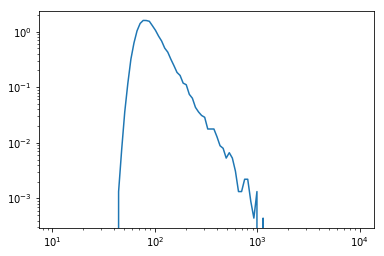

In [18]:
with h5.File( likelihood_file_IGM, 'r' ) as f:
    print( f['alpha1-3rd/far/4/|RM|/0.1000'].keys() )
    
    P, x = [f['primordial/far/4/DM/0.1000/%s' % axis] for axis in ['P','x']]
    
    print(P[27])
    
    print(np.sum(P*np.diff(x)))
    print(np.sum(P[()]*np.diff(x[()])))
    
    PlotLikelihood( x=x, P=P )
    
    print(np.sum(P*np.diff(x)))
    print(np.sum(P[()]*np.diff(x[()])))
        
    

In [21]:
a = np.ones(3)
def f(a):
    b= a.copy()
    b*=2

f(a)    
print(a)

[1. 1. 1.]


<Closed HDF5 dataset>